In [1]:
import pandas as pd
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style("ticks")

Olist conducted an experiment to see if altering the delivery estimation could result in higher review scores.

# Generate random data for A/B testing

In [13]:
date_range = pd.date_range(start="2018-07-01", end="2018-09-01")

In [14]:
date_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
               '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
               '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
               '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
               '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
      

In [15]:
np.datetime64("2018-07-15")

numpy.datetime64('2018-07-15')

In [16]:
control = {1: 10,
           2: 3,
           3: 8,
           4: 20,
           5: 59}

test = {1: 10,
        2: 2,
        3: 10,
        4: 22,
        5: 63}

def generate_review_distribution(freq_dict):
    l = []
    for key, value in freq_dict.items():
        l += [key] * value
    return l

In [17]:
def get_random_review(date, group):
    if (group == 102) & (date >= np.datetime64("2018-07-15")):
        random_reviews = generate_review_distribution(test)
    else:
        random_reviews = generate_review_distribution(control)
    return random.choice(random_reviews)
    
def generate_random_observation(date, group):
    return str(uuid.uuid4()), get_random_review(date, group)

In [23]:
# create list of dicts to later on convert to a dataframe
rows = []
for date in date_range:
    # two groups
    for group in [101,102]:
        # pick a random number of orders btw 350 and 450
        orders = random.choice(range(350,450))
        for obs in range(orders):
            order_id, review_score = generate_random_observation(date, group)
            rows.append({"date_id": date,
                         "experiment_id": group,
                         "order_id": order_id,
                         "review_score": review_score})
            
df = pd.DataFrame(rows)

### Plot data and calculate means

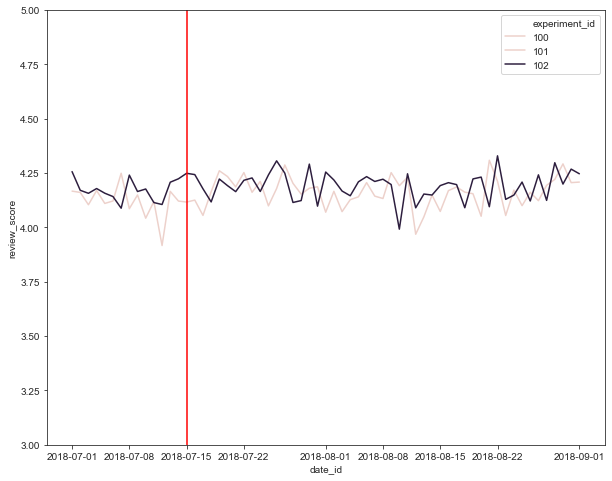

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df.groupby(["date_id", "experiment_id"]).mean().reset_index(),
             x="date_id",
             y="review_score",
             hue="experiment_id",
             ax=ax);
ax.axvline("2018-07-15", color="r")
ax.set_ylim(3,5);

In [61]:
df[df["date_id"] >= "2018-07-15"].groupby("experiment_id").mean()

,review_score
experiment_id,
101,4.163555
102,4.192783


In [28]:
df.to_csv("data/olist_experiment_data.csv")

In [6]:
df = (pd.read_csv("data/olist_experiment_data.csv")
      .drop(columns="Unnamed: 0"))
df["date_id"] = pd.to_datetime(df["date_id"])

How do we know if this difference did not just occure by chance?
We have uncertainty because we are looking at a sample and want to generalize to all users.


We use statistics => t-test

Use the Welch's t-test (two independent samples, unequal sample sizes, unequal variance (Heteroskedasticity))

In [8]:
df_e = df.loc[df["date_id"] >= "2018-07-15"]

group_a = df_e.loc[df["experiment_id"] == 101, "review_score"]
group_b = df_e.loc[df["experiment_id"] == 102, "review_score"]

t, p = scipy.stats.ttest_ind(group_a, group_b, equal_var=False)

In [9]:
p

0.021839698249793767

In [10]:
print(f"the p-value is {round(p * 100, 3)}%")

the p-value is 2.184%


In [11]:
print(f"the t-statistic is {round(t, 3)}")

the t-statistic is -2.293


### What the $(@! is the p-value?

# Central Limit Theorem


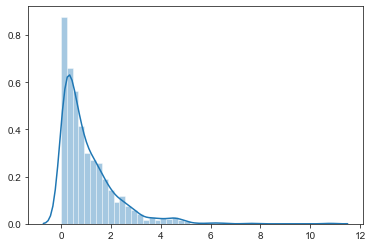

In [27]:
sns.distplot(np.random.exponential(size=1000));

In [38]:
sample_1 = np.random.exponential(size=1000) * 100

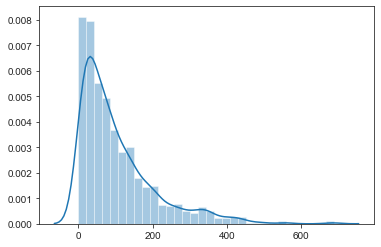

In [39]:
sns.distplot(sample_1)

In [41]:
sample_1.mean()

103.52577018253984

In [42]:
sample_2 = np.random.exponential(size=1000) * 100
sample_2.mean()

99.11121552925978

In [43]:
sample_3 = np.random.exponential(size=1000) * 100
sample_3.mean()

104.94795977316247

In [56]:
def plot_hist(n_samples, sample_size, ax):
    sample_means = [(np.random.exponential(size=sample_size) * 100).mean() for i in range(n_samples)]
    sns.distplot(sample_means, ax=ax)

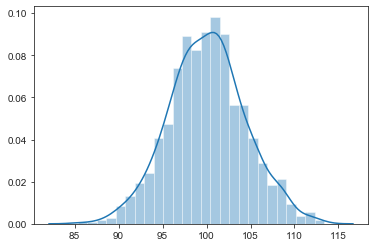

In [55]:
plot_hist(n_samples=1000, sample_size=500)

Tweak the sample size parameter and check its influence on the shape

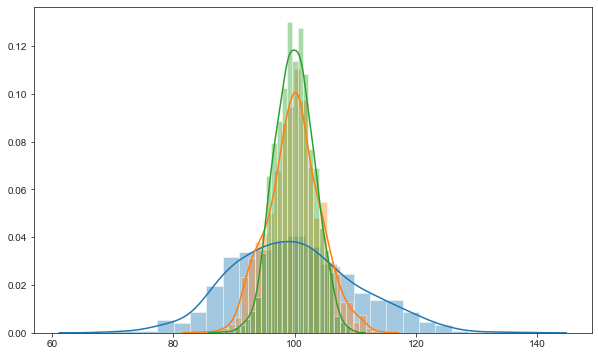

In [57]:
fig, ax = plt.subplots(figsize=(10,6))

plot_hist(n_samples=1000, sample_size=100, ax=ax)
plot_hist(n_samples=1000, sample_size=500, ax=ax)
plot_hist(n_samples=1000, sample_size=1000, ax=ax)

Tweak the number of samples you are taking and check its influence on the shape

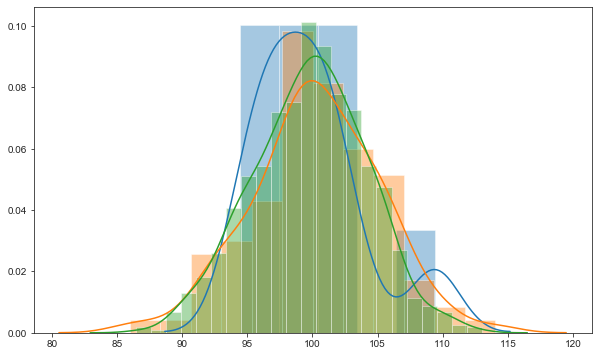

In [64]:
fig, ax = plt.subplots(figsize=(10,6))

plot_hist(n_samples=10, sample_size=500, ax=ax)
plot_hist(n_samples=100, sample_size=500, ax=ax)
plot_hist(n_samples=1000, sample_size=500, ax=ax)

# Analysis

Testing the hypothesis:

Nullhypothesis:

$H_0 : avg\_score_{control} = avg\_score_{test}$

$<=> H_0 : avg\_score_{control} - avg\_score_{test} = 0$

Against the alternative hypothesis:

$H_1 : avg\_score_{control} - avg\_score_{test} \neq 0$

-> The treatment had a non-zero impact: The overestimationg of delivery_days had an impact on review_score

In [12]:
df.head()

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,51908820-b3c2-4a16-b263-d1e8ba9938db,5
1,2018-07-01,101,e056ada8-2188-482f-abaf-dfc7b9e3b111,4
2,2018-07-01,101,21ce6ec1-20a9-45ee-9c6d-3735338b9159,5
3,2018-07-01,101,392e3218-6e00-4c1e-a1b0-c7c46c4ed401,5
4,2018-07-01,101,02328e99-ad1d-4129-9bae-e00f23faac33,4


In [13]:
df.dtypes

date_id          datetime64[ns]
experiment_id             int64
order_id                 object
review_score              int64
dtype: object

In [14]:
df_exp = df[df["date_id"] >= "2018-07-15"].copy()

In [15]:
means = df_exp.groupby("experiment_id").mean()
means

,review_score
experiment_id,
101,4.163555
102,4.192783


In [16]:
var = df_exp.groupby("experiment_id").var()
var

,review_score
experiment_id,
101,1.641821
102,1.535421


In [17]:
stds = df_exp.groupby("experiment_id").std()
stds

,review_score
experiment_id,
101,1.281335
102,1.239121


In [18]:
ssizes = df_exp.groupby("experiment_id").size()
ssizes

experiment_id
101    19767
102    19343
dtype: int64

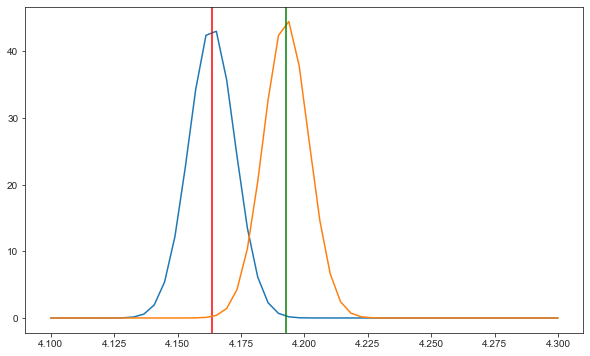

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(4.1, 4.3)

std_a = stds.loc[101, "review_score"] / np.sqrt(ssizes[101])
pdf_a = scipy.stats.norm.pdf(x,
                             means.loc[101, "review_score"],
                             std_a)

plt.plot(x, pdf_a);
ax.axvline(means.loc[101, "review_score"], color="r");

std_b = stds.loc[102, "review_score"] / np.sqrt(ssizes[102])
pdf_b = scipy.stats.norm.pdf(x,
                             means.loc[102, "review_score"],
                             std_b)

plt.plot(x, pdf_b);
ax.axvline(means.loc[102, "review_score"], color="g");

In [20]:
combined_standard_error = np.sqrt(var.loc[101, "review_score"]/ssizes[101] + var.loc[102, "review_score"]/ssizes[102])

In [21]:
combined_standard_error

0.012745089200171074

In [22]:
diff_mean = means.loc[101, "review_score"] - means.loc[102, "review_score"]

In [23]:
diff_mean

-0.02922749823480597

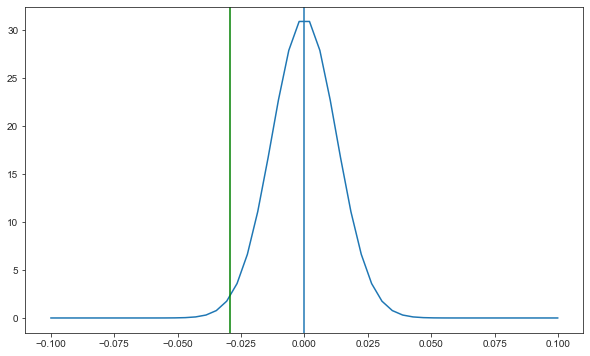

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(-.1,.1)
pdf_c = scipy.stats.norm.pdf(x,
                             0,
                             combined_standard_error)
plt.plot(x, pdf_c);
ax.axvline(0);
ax.axvline(diff_mean, color="g");

In [25]:
t = diff_mean / combined_standard_error
t

-2.2932360673014087

In [26]:
scipy.stats.ttest_ind(df_exp.loc[df_exp["experiment_id"] == 101, "review_score"],
                      df_exp.loc[df_exp["experiment_id"] == 102, "review_score"],
                      equal_var=False)

Ttest_indResult(statistic=-2.2932360673014096, pvalue=0.021839698249793767)

Applying an alpha-level of 5% (significance level), we reject the null hypothesis that the mean of both samples are equal. Hence, we conclude that the change we introduced (treatment) has had a statistically significant impact on the average review_score. The effect size is estimated to be approximately 0.029, resulting in an increase of average reivew_scores from 4.16 to 4.19.

## Interpreting the p-value

Given our samples, assuming the null hypothesis, the likelihood of obtaining the difference we observed or more extreme is 0.0218.

Generally: Given the data, assuming the null hypothesis is true, how likely is it that we obtain the value we observed or more extreme.

Say: How ridiculous is the null hypothesis?

---

# Plot 'convergence' (cumulative difference in means and confidence intervals)

In [27]:
def generate_cum_test_result(df, date_id):
    df_cum = df[df["date_id"].le(date_id)]
    means = df_cum.groupby("experiment_id").mean()["review_score"]
    var = df_cum.groupby("experiment_id").var()["review_score"]
    stds = df_cum.groupby("experiment_id").std()["review_score"]
    ssizes = df_cum.groupby("experiment_id").size()

    diff_mean = means[102] - means[101]
    combined_standard_error = np.sqrt(var[101]/ssizes[101] + var[102]/ssizes[102])
    
    test_result = scipy.stats.ttest_ind(df_cum[df_exp["experiment_id"] == 101]["review_score"],
                                        df_cum[df_exp["experiment_id"] == 102]["review_score"],
                                        equal_var=False)
    t = test_result.statistic
    p = test_result.pvalue
    return {"date_id": date_id,
            "diff_mean": diff_mean,
            "se": combined_standard_error,
            "lc": diff_mean - (1.96*combined_standard_error),
            "uc": diff_mean + (1.96*combined_standard_error),
            "t-statistic": t,
            "p-value": p}

In [28]:
df_cum = pd.DataFrame([generate_cum_test_result(df_exp, date) for date in pd.date_range(start="2018-07-15", end="2018-09-01")])

/Users/at/miniconda3/envs/backpack_banana/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/at/miniconda3/envs/backpack_banana/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [29]:
df_cum.head()

,date_id,diff_mean,se,lc,uc,t-statistic,p-value
0,2018-07-15,0.132332,0.087015,-0.038217,0.302881,-1.520803,0.128698
1,2018-07-16,0.125200,0.061531,0.004599,0.245800,-2.034743,0.042043
2,2018-07-17,0.122989,0.051602,0.021850,0.224128,-2.383429,0.017231
3,2018-07-18,0.082323,0.045227,-0.006323,0.170968,-1.820203,0.068824
4,2018-07-19,0.059521,0.040214,-0.019299,0.138340,-1.480104,0.138927


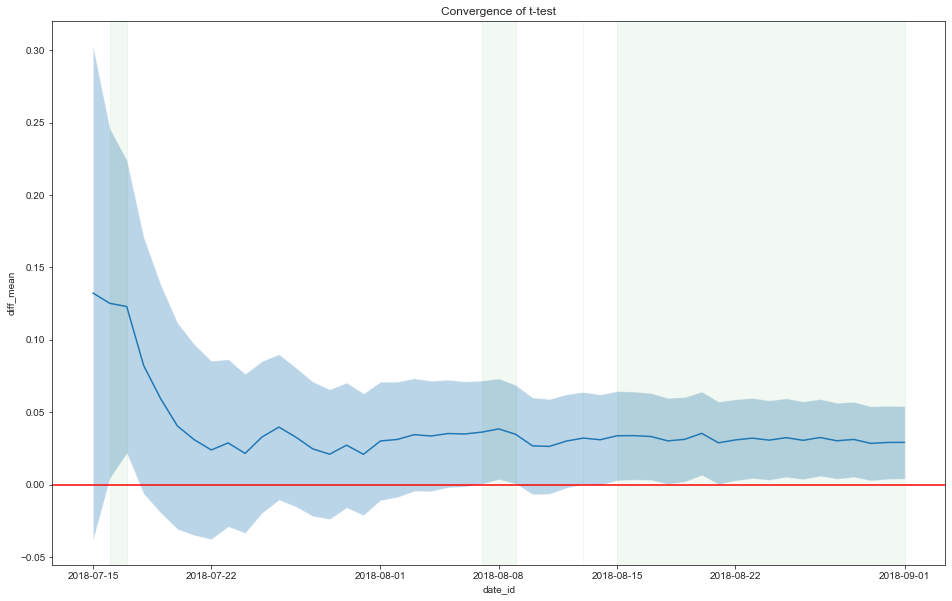

In [30]:
fig, ax = plt.subplots(figsize=(16,10))

sns.lineplot(data=df_cum,
             x="date_id",
             y="diff_mean");
ax.fill_between(df_cum["date_id"],
                df_cum["lc"],
                df_cum["uc"],
                alpha=0.3);
ax.axhline(0, color="r");
ax.set_title("Convergence of t-test");

# color areas that were significant
df_sig = df_cum.assign(significant=df_cum["p-value"].le(.05).astype(int))
df_sig = df_sig[df_sig["significant"].eq(1)]
df_sig = df_sig.assign(shifted_date=df_sig["date_id"].shift(1))
df_sig = df_sig.assign(new_range=(~df_sig["date_id"].eq(df_sig["shifted_date"] + np.timedelta64(1,"D"))).astype(int))
df_sig = df_sig.assign(range_id=df_sig["new_range"].cumsum()).drop(columns=["significant",
                                                                            "shifted_date",
                                                                            "new_range"])
for min_date, max_date in df_sig.groupby("range_id").agg({"date_id": ["min", "max"]}).values:
    ax.axvspan(min_date, max_date, color="g", alpha=.05);